In [1]:
import random
import os
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
import datetime
import scipy
from scipy.integrate import odeint
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st

import math
import xarray as xr
import emcee
import json

from covid19model.optimization import objective_fcns
from covid19model.models import models
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import model_parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot
from covid19model.models.time_dependant_parameter_fncs import ramp_fun, google_lockdown, google_lockdown_no_prev


# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

pd.plotting.register_matplotlib_converters()

# Data

In [2]:
# Load the interaction matrices (size: 9x9)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012',intensity='all')
# Define the number of age categories
levels = initN.size

initN, Nc_home_15, Nc_work_15, Nc_schools_15, Nc_transport_15, Nc_leisure_15, Nc_others_15, Nc_total_15 = model_parameters.get_interaction_matrices(dataset='willem_2012',intensity='more_15_min')
initN, Nc_home_1hr, Nc_work_1hr, Nc_schools_1hr, Nc_transport_1hr, Nc_leisure_1hr, Nc_others_1hr, Nc_total_1hr = model_parameters.get_interaction_matrices(dataset='willem_2012',intensity='more_one_hour')

In [3]:
Nc_all = {'total': Nc_total, 'home':Nc_home, 'work': Nc_work, 'schools': Nc_schools, 'transport': Nc_transport, 'leisure': Nc_leisure, 'others': Nc_others}
Nc_15min = {'total': Nc_total_15, 'home': Nc_home_15, 'work': Nc_work_15, 'schools': Nc_schools_15, 'transport': Nc_transport_15, 'leisure': Nc_leisure_15, 'others': Nc_others_15}
Nc_1hr = {'total': Nc_total_1hr, 'home': Nc_home_1hr, 'work': Nc_work_1hr, 'schools': Nc_schools_1hr, 'transport': Nc_transport_1hr, 'leisure': Nc_leisure_1hr, 'others': Nc_others_1hr}

In [4]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano['D_cumsum'] = df_sciensano.D_tot.cumsum()

In [5]:
df_google = google.get_google_mobility_data(update=False, plot=False)

In [6]:
nonpublic_ts = pd.read_csv('../../data/interim/non_public/all_nonpublic_timeseries.csv', parse_dates=['DATE'])
deceased_hosp = nonpublic_ts[['DATE','deceased_hosp']].groupby('DATE').sum()['2020-03-15':].reset_index()
deceased_hosp['D_cumsum'] = deceased_hosp.deceased_hosp.cumsum()

# Model

In [7]:
with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/google/BE_2020-11-10_WAVE1_GOOGLE.json', 'r') as fp:
    samples_dict = json.load(fp)


In [8]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({'df_google': df_google,
              'Nc_all' : Nc_all,
              'Nc_15min' : Nc_15min,
              'Nc_1hr' : Nc_1hr,
               'l' : 5,
               'tau' : 5,
              })

# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}

model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': google_lockdown_no_prev})

# Check hospitalised

In [9]:
start_calibration = '2020-03-15'
# Last datapoint used to calibrate basic reproduction number
end_calibration = '2020-05-04'

<IPython.core.display.Javascript object>


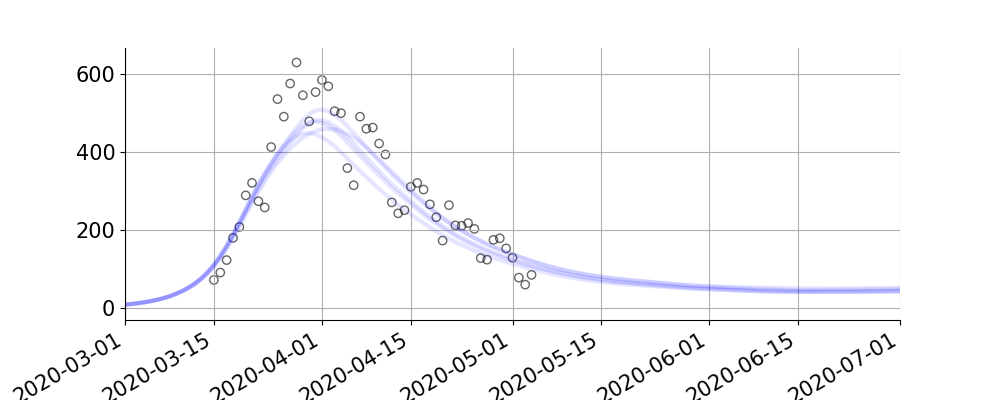

In [11]:
end_sim = '2020-07-01'

fig,ax=plt.subplots(figsize=(10,4))
for i in range(5):
    # Sampling
    model.parameters['beta'] = np.random.choice(samples_dict['beta'])
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]   
    # Simulate
    y_model = model.sim(end_sim, warmup=samples_dict['warmup'], start_date=start_calibration)
    # Plot
    ax.plot(y_model['time'],y_model["H_in"].sum(dim="Nc"),color='blue',alpha=0.1)

ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration],color='black',alpha=0.6,linestyle='None',facecolors='none')

ax.set_xlim('2020-03-01',end_sim)
fig.autofmt_xdate()


# Check deceased

Sciensano gives the total deceased (including nursery homes), but the model only predicts deceased from the hospital.

In [ ]:
samples_dict.keys()

<IPython.core.display.Javascript object>


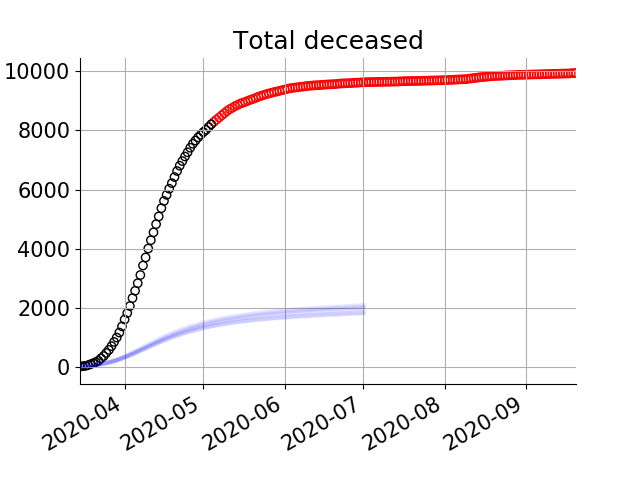

In [12]:
states = [['D']]
start_date = '15-03-2020'
end_date = '2020-09-20'
data=[df_sciensano[:samples_dict['end_wave1']]['D_cumsum'].values]
fig,ax=plt.subplots()

for i in range(5):
    # Sampling
    model.parameters['beta'] = np.random.choice(samples_dict['beta'])
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]   
    # Simulate
    y_model = model.sim(end_sim, warmup=samples_dict['warmup'], start_date=start_calibration)
    # Plot
    ax.plot(y_model['time'],y_model["D"].sum(dim="Nc"),color='blue',alpha=0.1)

data_before_calib = df_sciensano[pd.to_datetime(start_date):samples_dict['end_wave1']]['D_cumsum']
plt.scatter(data_before_calib.index, data_before_calib.values, marker='o',color='black',linestyle='None',facecolors='none')

data_after_calib = df_sciensano[pd.to_datetime(samples_dict['end_wave1'])+pd.to_timedelta('1d'):end_date]['D_cumsum']
plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')

plt.title('Total deceased')
ax.set_xlim(start_date, end_date)
fig.autofmt_xdate()

#leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
#ax.set_ylim([0,850])
#plt.savefig('plot_fit_compliance.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

<IPython.core.display.Javascript object>


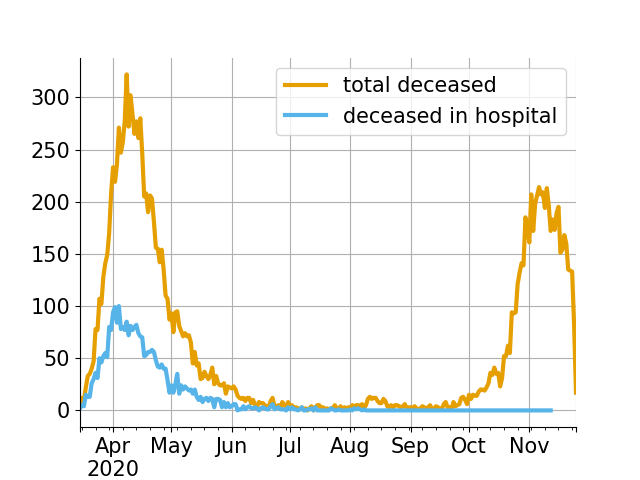

In [13]:
fig,ax = plt.subplots()
df_sciensano.reset_index().plot('DATE','D_tot', ax=ax, label="total deceased")
deceased_hosp.plot('DATE','deceased_hosp', ax=ax, label='deceased in hospital')

<IPython.core.display.Javascript object>


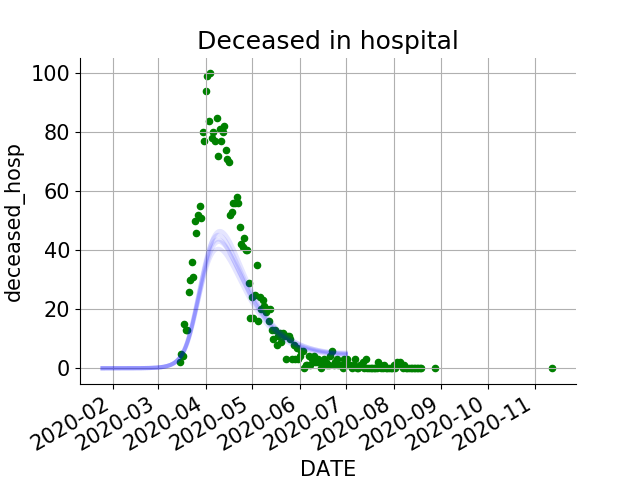

In [14]:
states = [['D']]
start_date = '15-03-2020'
end_date = '2020-08-01'
dates = pd.date_range(start_date, end_date)
data=[deceased_hosp.set_index('DATE')[:samples_dict['end_wave1']]['deceased_hosp'].values]
fig,ax=plt.subplots()
for i in range(5):
    # Sampling
    model.parameters['beta'] = np.random.choice(samples_dict['beta'])
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]   
    # Simulate
    y_model = model.sim(end_sim, warmup=samples_dict['warmup'], start_date=start_calibration)
    # Plot
    ax.plot(y_model['time'][1:],y_model["D"].sum(dim="Nc").diff(dim='time'),color='blue',alpha=0.1)


deceased_hosp.plot('DATE', 'deceased_hosp', kind='scatter', ax=ax, c='green')
plt.title('Deceased in hospital')
fig.autofmt_xdate()


<IPython.core.display.Javascript object>


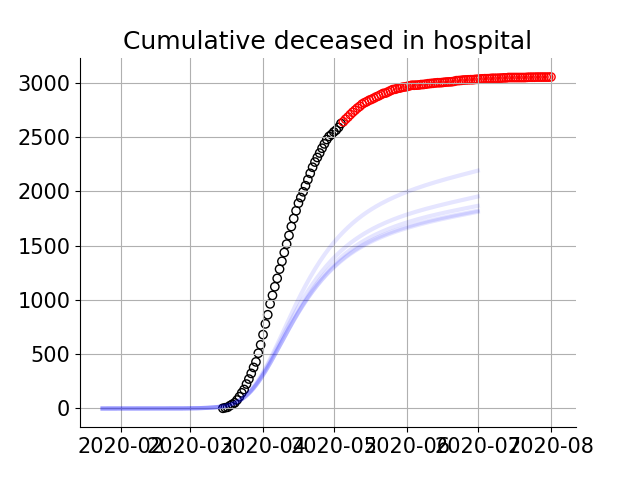

Text(0.5, 1.0, 'Cumulative deceased in hospital')

In [15]:
states = [['D']]
start_date = '15-03-2020'
end_date = '2020-08-01'
data=[deceased_hosp.set_index('DATE')[:samples_dict['end_wave1']]['D_cumsum'].values]
fig,ax=plt.subplots()
for i in range(5):
    # Sampling
    model.parameters['beta'] = np.random.choice(samples_dict['beta'])
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]   
    # Simulate
    y_model = model.sim(end_sim, warmup=samples_dict['warmup'], start_date=start_calibration)
    # Plot
    ax.plot(y_model['time'],y_model["D"].sum(dim="Nc"),color='blue',alpha=0.1)

data_before_calib = deceased_hosp.set_index('DATE')[pd.to_datetime(start_date):samples_dict['end_wave1']]['D_cumsum']
plt.scatter(data_before_calib.index, data_before_calib.values, marker='o',color='black',linestyle='None',facecolors='none')

data_after_calib = deceased_hosp.set_index('DATE')[pd.to_datetime(samples_dict['end_wave1'])+pd.to_timedelta('1d'):end_date]['D_cumsum']
plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
plt.title('Cumulative deceased in hospital')
#leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
#ax.set_ylim([0,850])
#plt.savefig('plot_fit_compliance.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

# Hospitalised per age class

In [16]:
start_date = '15-03-2020'
end_date = '2020-08-01'

In [18]:
hospitalised_per_age = {}
for age_class in np.arange(3,9):
    hospitalised_per_age[age_class] = pd.read_csv('../../data/interim/non_public/timeseries_arr/TS_arr_hospitalised_ageclass_'+str(age_class)+'.csv', parse_dates=['dt_admission'])
    hospitalised_per_age[age_class] = hospitalised_per_age[age_class].set_index('dt_admission')['2020-03-15':].sum(axis=1).reset_index().rename(columns={0:'hospitalised'})

In [19]:
dates = pd.date_range(start_date, end_date)

In [25]:
y_model.sel(Nc=i)['time']

<xarray.DataArray 'time' (time: 160)>
array(['2020-01-24T00:00:00.000000000', '2020-01-25T00:00:00.000000000',
       '2020-01-26T00:00:00.000000000', '2020-01-27T00:00:00.000000000',
       '2020-01-28T00:00:00.000000000', '2020-01-29T00:00:00.000000000',
       '2020-01-30T00:00:00.000000000', '2020-01-31T00:00:00.000000000',
       '2020-02-01T00:00:00.000000000', '2020-02-02T00:00:00.000000000',
       '2020-02-03T00:00:00.000000000', '2020-02-04T00:00:00.000000000',
       '2020-02-05T00:00:00.000000000', '2020-02-06T00:00:00.000000000',
       '2020-02-07T00:00:00.000000000', '2020-02-08T00:00:00.000000000',
       '2020-02-09T00:00:00.000000000', '2020-02-10T00:00:00.000000000',
       '2020-02-11T00:00:00.000000000', '2020-02-12T00:00:00.000000000',
       '2020-02-13T00:00:00.000000000', '2020-02-14T00:00:00.000000000',
       '2020-02-15T00:00:00.000000000', '2020-02-16T00:00:00.000000000',
       '2020-02-17T00:00:00.000000000', '2020-02-18T00:00:00.000000000',
       '2020-02-19T00:00:00.000000000', '2020-02-20T00:00:00.000000000',
       '2020-02-21T00:00:00.000000000', '2020-02-22T00:00:00.000000000',
       '2020-02-23T00:00:00.000000000', '2020-02-24T00:00:00.000000000',
       '2020-02-25T00:00:00.000000000', '2020-02-26T00:00:00.000000000',
       '2020-02-27T00:00:00.000000000', '2020-02-28T00:00:00.000000000',
       '2020-02-29T00:00:00.000000000', '2020-03-01T00:00:00.000000000',
       '2020-03-02T00:00:00.000000000', '2020-03-03T00:00:00.000000000',
       '2020-03-04T00:00:00.000000000', '2020-03-05T00:00:00.000000000',
       '2020-03-06T00:00:00.000000000', '2020-03-07T00:00:00.000000000',
       '2020-03-08T00:00:00.000000000', '2020-03-09T00:00:00.000000000',
       '2020-03-10T00:00:00.000000000', '2020-03-11T00:00:00.000000000',
       '2020-03-12T00:00:00.000000000', '2020-03-13T00:00:00.000000000',
       '2020-03-14T00:00:00.000000000', '2020-03-15T00:00:00.000000000',
       '2020-03-16T00:00:00.000000000', '2020-03-17T00:00:00.000000000',
       '2020-03-18T00:00:00.000000000', '2020-03-19T00:00:00.000000000',
       '2020-03-20T00:00:00.000000000', '2020-03-21T00:00:00.000000000',
       '2020-03-22T00:00:00.000000000', '2020-03-23T00:00:00.000000000',
       '2020-03-24T00:00:00.000000000', '2020-03-25T00:00:00.000000000',
       '2020-03-26T00:00:00.000000000', '2020-03-27T00:00:00.000000000',
       '2020-03-28T00:00:00.000000000', '2020-03-29T00:00:00.000000000',
       '2020-03-30T00:00:00.000000000', '2020-03-31T00:00:00.000000000',
       '2020-04-01T00:00:00.000000000', '2020-04-02T00:00:00.000000000',
       '2020-04-03T00:00:00.000000000', '2020-04-04T00:00:00.000000000',
       '2020-04-05T00:00:00.000000000', '2020-04-06T00:00:00.000000000',
       '2020-04-07T00:00:00.000000000', '2020-04-08T00:00:00.000000000',
       '2020-04-09T00:00:00.000000000', '2020-04-10T00:00:00.000000000',
       '2020-04-11T00:00:00.000000000', '2020-04-12T00:00:00.000000000',
       '2020-04-13T00:00:00.000000000', '2020-04-14T00:00:00.000000000',
       '2020-04-15T00:00:00.000000000', '2020-04-16T00:00:00.000000000',
       '2020-04-17T00:00:00.000000000', '2020-04-18T00:00:00.000000000',
       '2020-04-19T00:00:00.000000000', '2020-04-20T00:00:00.000000000',
       '2020-04-21T00:00:00.000000000', '2020-04-22T00:00:00.000000000',
       '2020-04-23T00:00:00.000000000', '2020-04-24T00:00:00.000000000',
       '2020-04-25T00:00:00.000000000', '2020-04-26T00:00:00.000000000',
       '2020-04-27T00:00:00.000000000', '2020-04-28T00:00:00.000000000',
       '2020-04-29T00:00:00.000000000', '2020-04-30T00:00:00.000000000',
       '2020-05-01T00:00:00.000000000', '2020-05-02T00:00:00.000000000',
       '2020-05-03T00:00:00.000000000', '2020-05-04T00:00:00.000000000',
       '2020-05-05T00:00:00.000000000', '2020-05-06T00:00:00.000000000',
       '2020-05-07T00:00:00.000000000', '2020-05-08T00:00:00.000000000',
       '2020-05-09T00:00:00.000000000', '2020-05-10T00:00:00.000000000',
       '2020-05-11T0

<IPython.core.display.Javascript object>


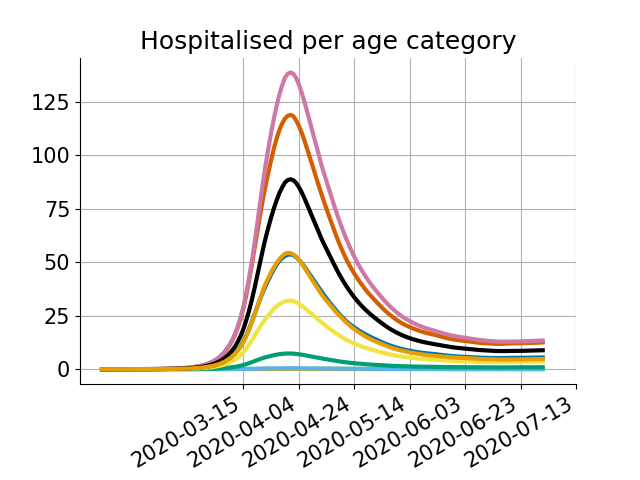

In [26]:
fig,ax = plt.subplots()
for i in range(9):
    plt.plot(y_model.sel(Nc=i)['time'], y_model.sel(Nc=i)['H_in'])
fig.autofmt_xdate()
ax.set_title('Hospitalised per age category')
ax.set_xticks(pd.date_range(start_date, end_date, freq='20D'))

<IPython.core.display.Javascript object>


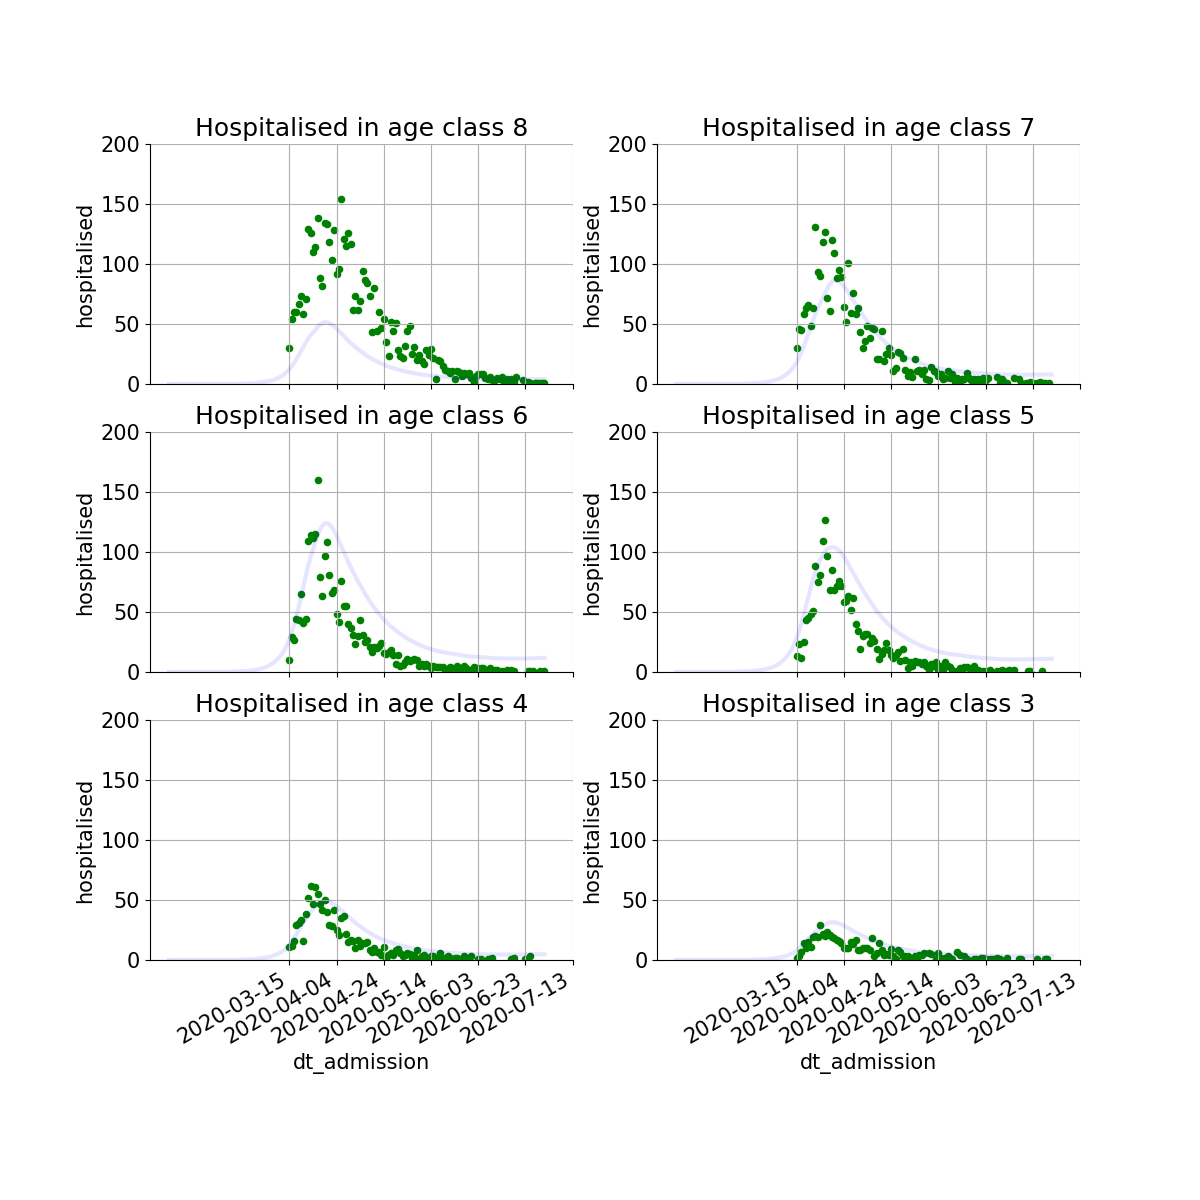

In [53]:
fig,axs = plt.subplots(nrows=3, ncols=2, figsize=(12,12))
for ax,age_class in zip(axs.flatten(), np.arange(8,2,-1)):
    for i in range(1):
        # Sampling
        model.parameters['beta'] = np.random.choice(samples_dict['beta'])
        idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
        model.parameters['tau'] = samples_dict['tau'][idx]   
        # Simulate
        y_model = model.sim(end_sim, warmup=samples_dict['warmup'], start_date=start_calibration)
        # Plot
        ax.plot(y_model['time'],y_model["H_in"].sel(Nc=age_class),color='blue',alpha=0.1)
        
    hospitalised_per_age[age_class].plot('dt_admission', 'hospitalised', kind='scatter', ax=ax, c='green')
    fig.autofmt_xdate()
    ax.set_ylim(0,200)
    ax.set_xticks(pd.date_range(start_date, end_date, freq='20D'))
    ax.set_title('Hospitalised in age class '+str(age_class))


# Deceased per age class

In [30]:
start_date = '15-03-2020'
end_date = '2020-08-01'

In [32]:
deceased_per_age = {}
deceased_per_age_cum = {}
for age_class in np.arange(3,9):
    deceased_per_age[age_class] = pd.read_csv('../../data/interim/non_public/timeseries_arr/TS_arr_deceased_ageclass_'+str(age_class)+'.csv', parse_dates=['dt_admission'])
    deceased_per_age[age_class] = deceased_per_age[age_class].set_index('dt_admission')['2020-03-15':].sum(axis=1).reset_index().rename(columns={0:'deceased'})
    deceased_per_age_cum[age_class] = deceased_per_age[age_class].set_index('dt_admission')['2020-03-15':].sum(axis=1).cumsum().reset_index().rename(columns={0:'deceased'})

<IPython.core.display.Javascript object>


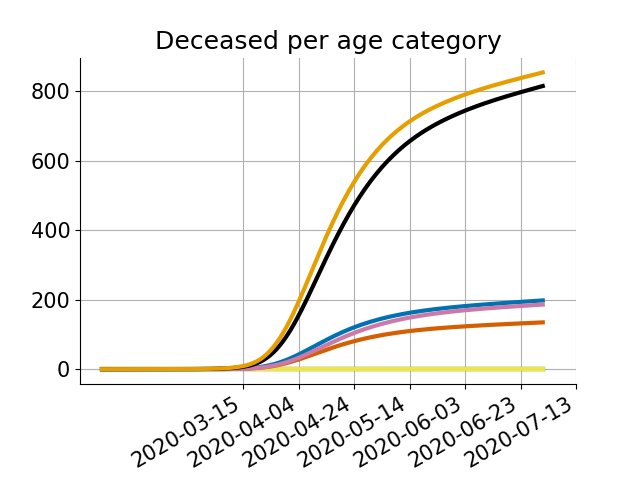

In [34]:
fig,ax = plt.subplots()
for i in range(9):
    plt.plot(y_model.sel(Nc=i)['time'], y_model.sel(Nc=i)['D'])
fig.autofmt_xdate()
ax.set_title('Deceased per age category')
ax.set_xticks(pd.date_range(start_date, end_date, freq='20D'))

<IPython.core.display.Javascript object>


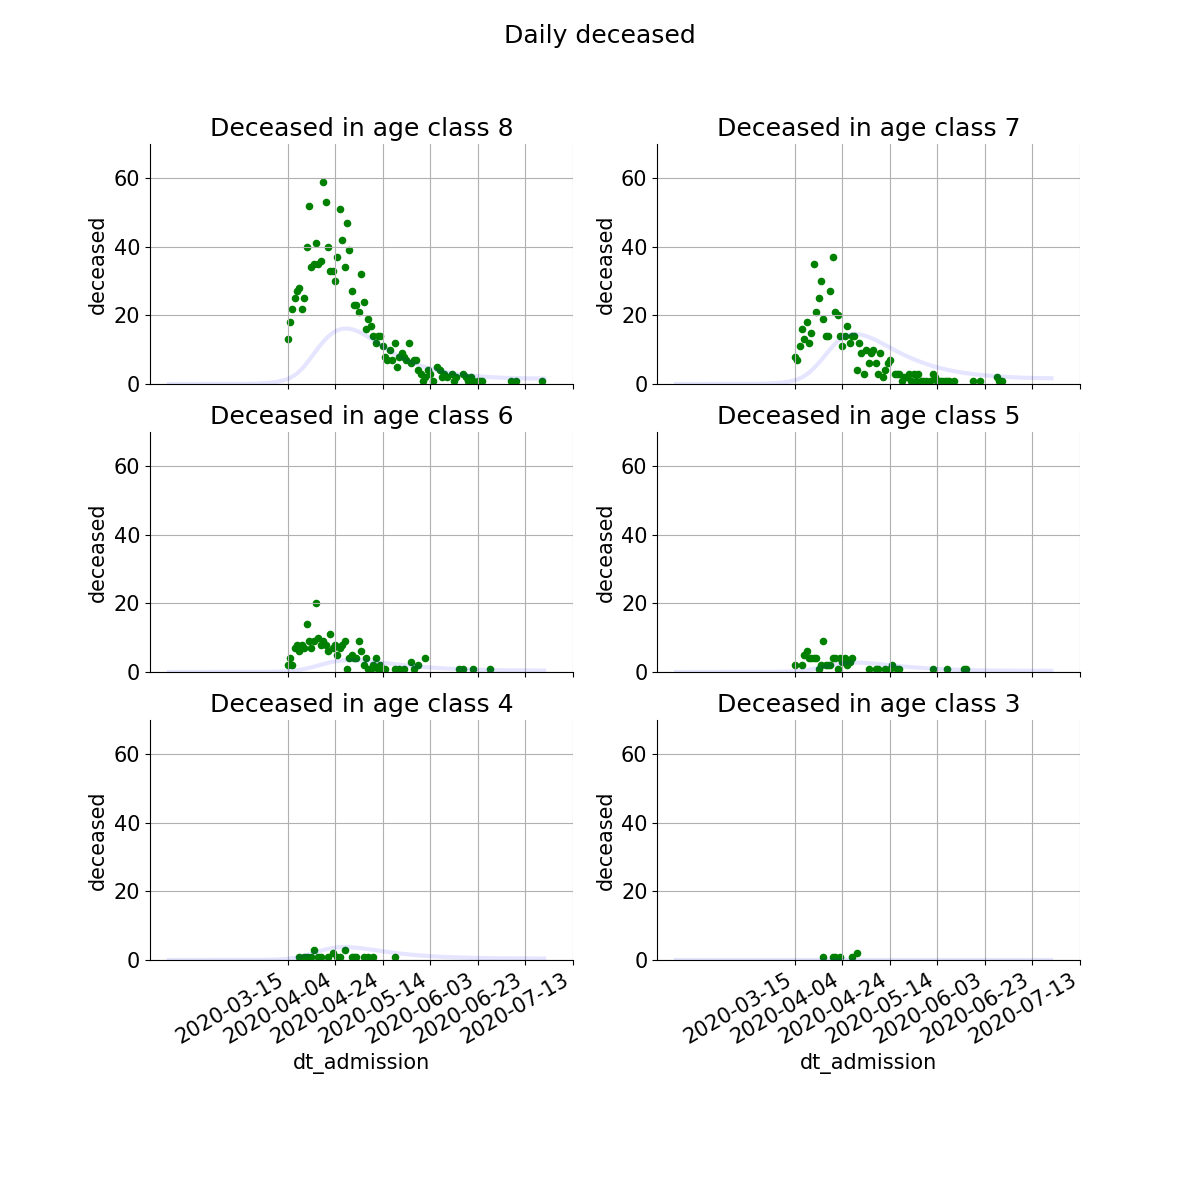

Text(0.5, 0.98, 'Daily deceased')

In [61]:
fig,axs = plt.subplots(nrows=3, ncols=2, figsize=(12,12))
for ax,age_class in zip(axs.flatten(), np.arange(8,2,-1)):
    for i in range(1):
        # Sampling
        model.parameters['beta'] = np.random.choice(samples_dict['beta'])
        idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
        model.parameters['tau'] = samples_dict['tau'][idx]   
        # Simulate
        y_model = model.sim(end_sim, warmup=samples_dict['warmup'], start_date=start_calibration)
        # Plot
        ax.plot(y_model['time'][1:],y_model["D"].sel(Nc=age_class).diff(dim='time'),color='blue',alpha=0.1)
        
    
    deceased_per_age[age_class].plot('dt_admission', 'deceased', kind='scatter', ax=ax, c='green')
    fig.autofmt_xdate()
    ax.set_xticks(pd.date_range(start_date, end_date, freq='20D'))
    ax.set_title('Deceased in age class '+str(age_class))
    ax.set_ylim(0,70)
plt.suptitle('Daily deceased')

<IPython.core.display.Javascript object>


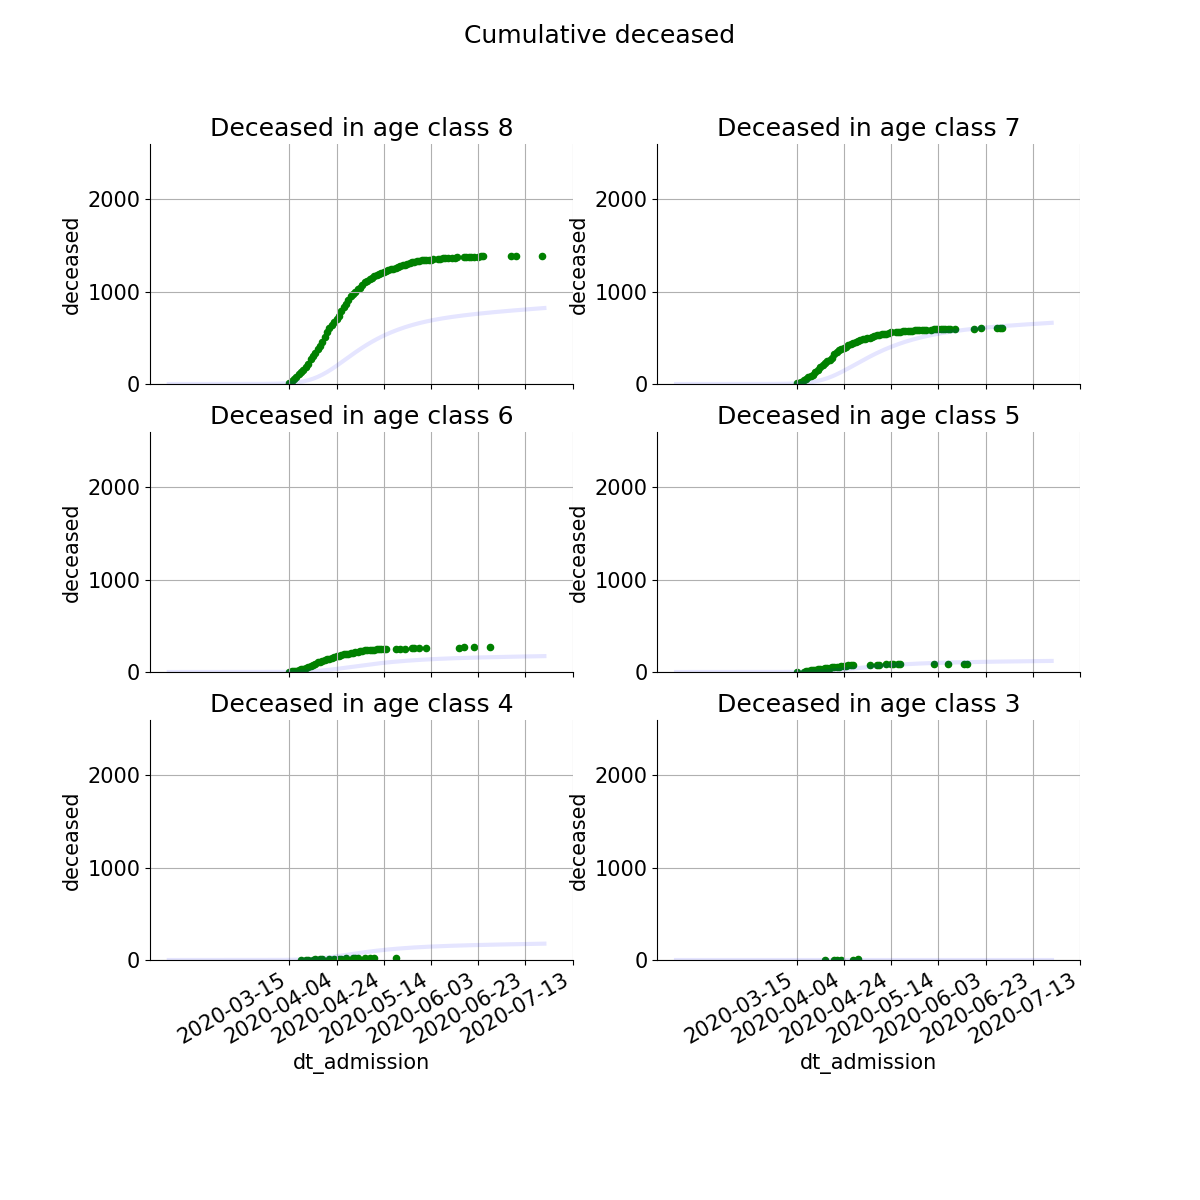

Text(0.5, 0.98, 'Cumulative deceased')

In [62]:
fig,axs = plt.subplots(nrows=3, ncols=2, figsize=(12,12))
for ax,age_class in zip(axs.flatten(), np.arange(8,2,-1)):

    for i in range(1):
        # Sampling
        model.parameters['beta'] = np.random.choice(samples_dict['beta'])
        idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
        model.parameters['tau'] = samples_dict['tau'][idx]   
        # Simulate
        y_model = model.sim(end_sim, warmup=samples_dict['warmup'], start_date=start_calibration)
        # Plot
        ax.plot(y_model['time'],y_model["D"].sel(Nc=age_class),color='blue',alpha=0.1)
        
#     for i in range(10):
#         idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
#         idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
#         model.parameters['tau'] = samples_dict['tau'][idx]
#         prevention = samples_dict['prevention'][idx]
#         # Create a dictionary of past policies
#         chk = {'time':   [start_date], 
#               'Nc':      [prevention*(1.00*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)]
#               }
#         y_model = model.sim(time=end_date, excess_time=lag_time,checkpoints=chk)
#         ax.plot(dates, y_model.sel(stratification=age_class)['D'][lag_time:], c='red', alpha=0.5)
    deceased_per_age_cum[age_class].plot('dt_admission', 'deceased', kind='scatter', ax=ax, c='green')
    fig.autofmt_xdate()
    ax.set_xticks(pd.date_range(start_date, end_date, freq='20D'))
    ax.set_title('Deceased in age class '+str(age_class))
    ax.set_ylim(0,2600)
plt.suptitle('Cumulative deceased')